In [2]:
!pip install monai thop pydicom
# !pip install gdcm pylibjpeg pylibjpeg-libjpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.6 MB/s eta 0:00:0000:010:01


In [3]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-04-03 00:16:03.850333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 00:16:03.850488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 00:16:03.989670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

2024-04-03 00:16:43.427688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 00:16:43.427745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 00:16:43.429148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

In [5]:
import pandas as pd
import pydicom
from torchvision import transforms
import pickle
import cv2

from sklearn.model_selection import train_test_split

# Timing utility
from timeit import default_timer as timer
from tqdm import tqdm

import torch
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


print("all imported")

set_determinism(seed=0)

all imported


In [6]:
diseases = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass',
 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
 'Pulmonary fibrosis']

# decided on the basis of frequency of occurence of individual diseases in images.

# Drop columns not in the list
columns_to_keep = diseases.copy()
columns_to_keep.append('image_id')

print(diseases)
print(columns_to_keep)

['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis', 'image_id']


In [7]:
# some helper functions:-

def delete_columns(df, columns_to_keep=columns_to_keep, root_folder='/train'):
    columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
    print("COLUMNS to drop:", columns_to_drop)
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Deleted columns from {root_folder.split('/')[-1]} folder")
    return df

def remove_all_zeros(df, diseases=diseases, root_folder='/train'):
    # Remove rows where all values are 0 in the disease labels
    df = df[(df[diseases] != 0).any(axis=1)]
    df.reset_index(drop=True, inplace=True)
    return df

def add_file_path_column(df, root_folder='/train'):
    df['file_path'] = df['image_id'].apply(lambda x: os.path.join(root_folder, f"{x}.npy")) # adjust dicom or png
    print(f"Added file_path column to {root_folder.split('/')[-1]} folder")
    return df



In [8]:
import pandas as pd

# Load the original CSV file
train_data = pd.read_csv("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv")


# Extract unique pairs of class_id and class_name
class_mapping = train_data[['class_id', 'class_name']].drop_duplicates()

# Sort the mapping by class_id
class_mapping = class_mapping.sort_values(by='class_id')

# Display the sorted mapping without the index
print(class_mapping.to_string(index=False))

disease_labels = class_mapping['class_name'].values
print("Disease LABELS :", disease_labels)
print('-'*100)

print("Now converting into one hot vector format")
### Convert the csv into image_id -> 0,0,0, ..... 1., 0, 1 (15 labels format)

# Convert class_id to string to enable one-hot encoding
train_data['class_id'] = train_data['class_id'].astype(str)

# Perform one-hot encoding to convert class IDs into binary columns
one_hot_encoded = pd.get_dummies(train_data['class_id'])

# Convert boolean values to integers (0 for False, 1 for True)
one_hot_encoded = one_hot_encoded.astype(int)

# Concatenate one-hot encoded columns with original DataFrame
train_data = pd.concat([train_data, one_hot_encoded], axis=1)
# print(train_data.columns)

# Group by image ID and aggregate the one-hot encoded class columns for each class separately
train_data = train_data.groupby('image_id').agg({
#     'width': 'first',
#     'height': 'first',
    '0': 'max', '1': 'max', '2': 'max', '3': 'max', '4': 'max',
    '5': 'max', '6': 'max', '7': 'max', '8': 'max', '9': 'max',
    '10': 'max', '11': 'max', '12': 'max', '13': 'max', '14': 'max'
}).reset_index()



print("UNIQUE images IN THE DATASET:", len(train_data.image_id.unique()))
print("num rows in dataset  :", len(train_data))
# train_data.head()

# Count occurrences of each class
class_counts = train_data.iloc[:, 1:].sum()
print("TOTAL Individual class counts:-\n", class_counts)
print('-'*100)


# the 14 th class is no finding...


# Save the new DataFrame to a new CSV file
# train_data.to_csv("one_hot_vector_data.csv", index=False)


# Check if 'no-finding' class is marked while any other abnormality class is also marked
# for index, row in train_data.iterrows():
#     if row['14'] == 1 and row.iloc[1:].sum() > 1:
#         print("Issue found in row:", index)
#         print("Other abnormality classes also marked in this row.")



# Rename the one-hot encoded columns
train_data = train_data.rename(columns=dict(zip(train_data.columns[1:], disease_labels)))
print("Renamed the columns from numbers to disease_label names")


### Removing the 'no finding label' ###
# train_data = delete_columns(train_data, columns_to_keep=columns_to_keep, root_folder='train')
# train_data = remove_all_zeros(train_data, diseases=diseases, root_folder='train')



## Adding file_path column
train_data = add_file_path_column(train_data, root_folder='/kaggle/input/vinbigdata-512-voi-clahe/vinbigdata-512-resized-clahe2-8,8_train')

# Split 10% of the training data as validation data, with random_state=42, for reproducibility
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5,random_state=42)


# reducing the size (comment this)
# train_data = train_data.head(500)
# val_data = val_data.head(500)
# test_data = test_data.head(500)

# Resetting the index, very important
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

### ADJUST diseases & disease_labels ###
# collecting & storing the labels separately
train_paths = train_data['file_path'].values
train_labels = train_data[disease_labels].values

val_paths = val_data['file_path'].values
val_labels = val_data[disease_labels].values

test_paths = test_data['file_path'].values
test_labels = test_data[disease_labels].values



print("length of train:", len(train_data), len(train_paths), len(train_labels))
print("length of val:", len(val_data), len(val_data), len(val_data))
print("length of test:", len(test_data), len(test_data), len(test_data))


print("Unique image_ids in train:", len(train_data['image_id'].unique()))
print("Unique image_ids in val:", len(val_data['image_id'].unique()))
print("Unique image_ids in test:", len(test_data['image_id'].unique()))

# train_data.info() except image_id all the other columns are of int datatype



 class_id         class_name
        0 Aortic enlargement
        1        Atelectasis
        2      Calcification
        3       Cardiomegaly
        4      Consolidation
        5                ILD
        6       Infiltration
        7       Lung Opacity
        8        Nodule/Mass
        9       Other lesion
       10   Pleural effusion
       11 Pleural thickening
       12       Pneumothorax
       13 Pulmonary fibrosis
       14         No finding
Disease LABELS : ['Aortic enlargement' 'Atelectasis' 'Calcification' 'Cardiomegaly'
 'Consolidation' 'ILD' 'Infiltration' 'Lung Opacity' 'Nodule/Mass'
 'Other lesion' 'Pleural effusion' 'Pleural thickening' 'Pneumothorax'
 'Pulmonary fibrosis' 'No finding']
----------------------------------------------------------------------------------------------------
Now converting into one hot vector format
UNIQUE images IN THE DATASET: 15000
num rows in dataset  : 15000
TOTAL Individual class counts:-
 0      3067
1       186
2       452
3

In [9]:
# Count occurrences of each class
class_counts = train_data.iloc[:, 1:-1].sum()
print("TRAIN Individual class counts:-\n", class_counts)

# Count occurrences of each class
class_counts = val_data.iloc[:, 1:-1].sum()
print("VAL Individual class counts:-\n", class_counts)

# Count occurrences of each class
class_counts = test_data.iloc[:, 1:-1].sum()
print("TEST Individual class counts:-\n", class_counts)

TRAIN Individual class counts:-
 Aortic enlargement    2459
Atelectasis            158
Calcification          360
Cardiomegaly          1842
Consolidation          288
ILD                    307
Infiltration           501
Lung Opacity          1092
Nodule/Mass            665
Other lesion           914
Pleural effusion       826
Pleural thickening    1598
Pneumothorax            74
Pulmonary fibrosis    1301
No finding            8489
dtype: int64
VAL Individual class counts:-
 Aortic enlargement     299
Atelectasis             10
Calcification           47
Cardiomegaly           217
Consolidation           34
ILD                     45
Infiltration            62
Lung Opacity           117
Nodule/Mass             78
Other lesion           111
Pleural effusion       112
Pleural thickening     199
Pneumothorax            14
Pulmonary fibrosis     172
No finding            1051
dtype: int64
TEST Individual class counts:-
 Aortic enlargement     309
Atelectasis             18
Calcification 

In [10]:
train_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,file_path
0,a762d86c37354288cbee2a68d3f7fd10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,a4af74fcb9ab6871e5a2d0521c3a61f9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,797cb8cc2ec5188b41e85add08014d6f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,bf1a313484d978612f2b3735600e2db9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,0e2c49d7d9a4db2f61776c970a463361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


In [11]:
val_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,file_path
0,eeb6f0e5be5c38812e9204b7689d6d18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,3286115baacb6ed3affc5c46c9205b7a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,aa95074ff365c4d60210bed08e92fc23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,de4917c51024b4f810868d211e4f4d40,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,9259faeeda26a934fb32c74b8682e15f,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


In [12]:
test_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,file_path
0,d7210d8d2f377ab74e46acfb4a158e79,1,0,0,1,0,0,0,1,1,1,0,0,0,1,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,998b7cc5e6e50e0353fcd1ce230f7f92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,e181e1775224e3191b0f79f07943e49a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,9a3994e6a7e4c6d815db35eff5203056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,aa0202259a3cba71d0e72468e2d9c3e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


### Visualising the images

In [13]:
train_image_files = [
    os.path.join('/', train_paths[i]) for i in range(len(train_paths))
]
print(len(train_image_files))

val_image_files = [
    os.path.join('/', val_paths[i]) for i in range(len(val_paths))
]
print(len(val_image_files))

test_image_files = [
    os.path.join('/', test_paths[i]) for i in range(len(test_paths))
]
print(len(test_image_files))

12000
1500
1500


In [14]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8)):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
#     data = data.astype(np.float32)
#     data = (data * 255.0).astype(np.float32) # no need for this I think 

    if apply_clahe:
        data = apply_clahe_to_image(data, clipLimit=clipLimit, tileGridSize=tileGridSize)
        
    return data



def apply_clahe_to_image(image, clipLimit=2.0, tileGridSize=(8,8)):
    # Convert image to uint16
    image = (image * 65535).astype(np.uint16)
    
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    # Apply CLAHE
    clahe_image = clahe.apply(image)
    
    # Convert image back to float32 in range [0, 1]
    clahe_image = clahe_image.astype(np.float32) / 65535.0
    
    return clahe_image



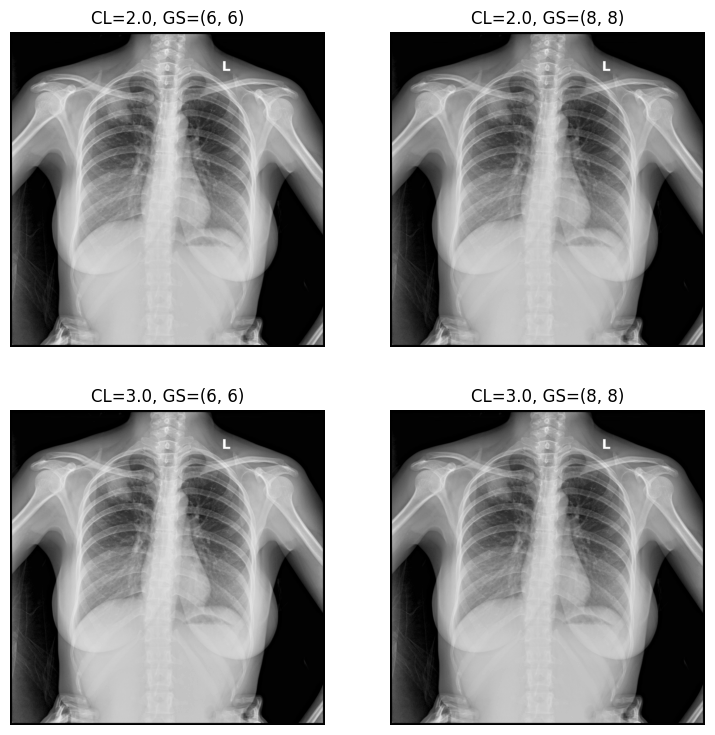

In [15]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()


path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0005e8e3701dfb1dd93d53e2ff537b6e.dicom'
# path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0007d316f756b3fa0baea2ff514ce945.dicom'
# path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/003cfe5ce5c0ec5163138eb3b740e328.dicom'
# path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0076d6a1e3139927fd62459c54276c3c.dicom'
# path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0101ad90f31ddb8fb24e9935a3dac9db.dicom'


clipLimits = [2.0, 3.0]
tileGridSizes = [(6,6),(8,8)]
images = []
titles = []


for clipLimit in clipLimits:
    for tileSize in tileGridSizes:
        images.append(read_xray(path, clipLimit=clipLimit, tileGridSize=tileSize))
        titles.append(f"clipLimit={clipLimit}, tileGridSize={tileSize}")
    
titles = [f"CL={clipLimit}, GS={tileSize}" for clipLimit in clipLimits for tileSize in tileGridSizes]
plot_images(images, titles, len(clipLimits), len(tileGridSizes))

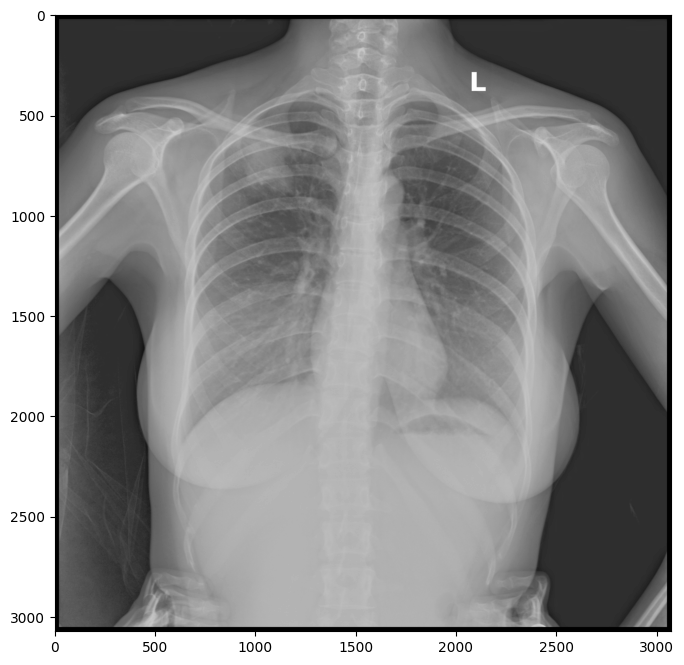

In [16]:
img = read_xray(path, voi_lut=False, apply_clahe=False)
plt.figure(figsize = (8,8))
# plt.imshow(img, cmap='bone')
plt.imshow(img, cmap='gray')

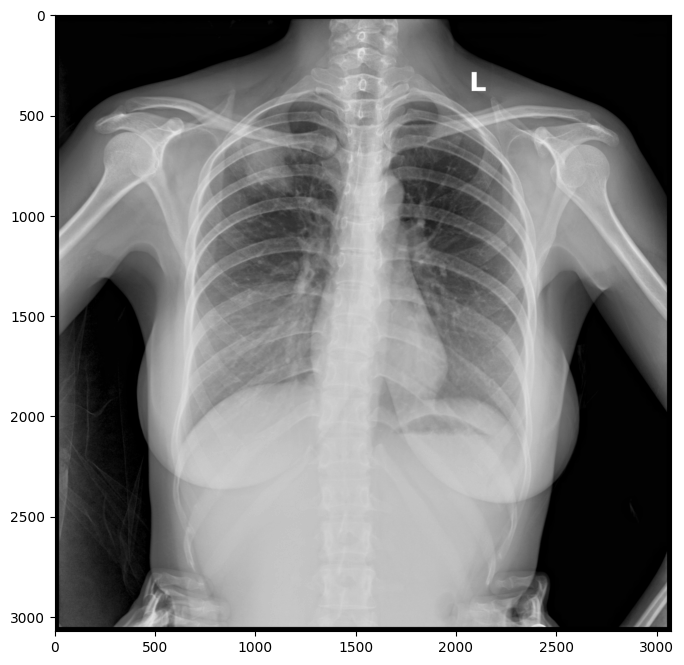

In [17]:
img = read_xray(path, voi_lut=True, apply_clahe=False)
plt.figure(figsize = (8,8))
# plt.imshow(img, cmap='bone')
plt.imshow(img, cmap='gray')

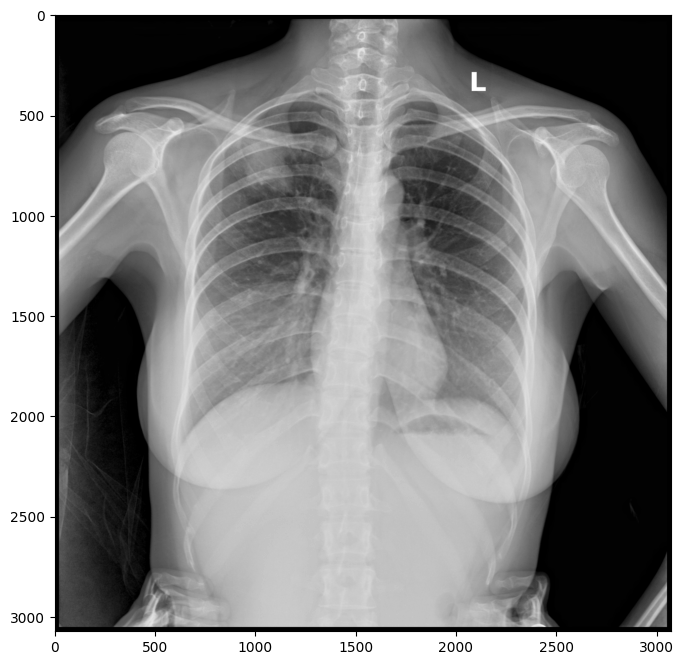

In [18]:
# the best configuration
img = read_xray(path, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8))
plt.figure(figsize = (8,8))
# plt.imshow(img, cmap='bone')
plt.imshow(img, cmap='gray')

#### The preprocessed saved images:-

image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)


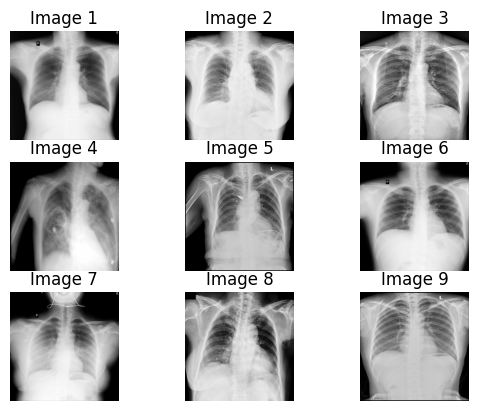

In [19]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Assuming train_image_files is a list of DICOM file paths
# Example:
# train_image_files = ["path/to/dicom/file1.dcm", "path/to/dicom/file2.dcm", ...]

for i, k in enumerate(np.random.randint(len(train_image_files), size=9)):


#     print("Image path", train_image_files[k])
    img_mat = np.load(train_image_files[k])

#     img_mat = cv2.imread(train_image_files[k])
# #     img_mat = cv2.resize(img_mat, (224, 224))
#     img_black = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
    float64_image_array = img_mat.astype(np.float64)

    
    print("image_shape:", img_mat.shape)
    
    # Visualization using Matplotlib
    plt.subplot(3, 3, i + 1)
    plt.imshow(float64_image_array, cmap='gray')  # Assuming grayscale DICOM images
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


In [20]:
BATCH_SIZE = 8
IMAGE_SIZE = (224,224) # the size to which the image would be resized before passing to the model
# num_classes = len(diseases)
num_classes = len(train_data.columns) - 2 
## ADJUST num_classes accordingly 

print("BATCH_SIZE: ", BATCH_SIZE) 
print("IMAGE_SIZE: ", IMAGE_SIZE) 
print("num_classes: ", num_classes) 

BATCH_SIZE:  8
IMAGE_SIZE:  (224, 224)
num_classes:  15


In [21]:
from monai.transforms import Compose, Lambda, EnsureChannelFirst, ScaleIntensity,\
 RandRotate, RandFlip, RandZoom, RandSpatialCrop, RandRotate90, ResizeWithPadOrCrop, Resize

def load_tensor(data):
    # Convert the data to a supported data type (e.g., float32)
    return data.astype(np.float32)


train_transforms = Compose(
    [
#         LoadImage(image_only=True), 
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         RandSpatialCrop(IMAGE_SIZE[0],IMAGE_SIZE[1]), random_size=False), # crops randomly ; loss of information
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE), # this will centrally crop : loss of information
#         RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensity(),
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
#         RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
#         LoadImage(image_only=True),
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE), # this will centrally crop : loss of information
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),

        ScaleIntensity(),

    ]
)

# y_pred_trans = Compose([Activations(softmax=True)])
# y_trans = Compose([AsDiscrete(to_onehot=num_class)])

y_pred_trans = Compose([Activations(sigmoid=True)]) # for multi-label classfication
y_trans = Compose([AsDiscrete(threshold_values=True)])


In [22]:
class VINDR_BigData_Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, in_chans=1, transforms=None):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        self.target_size = IMAGE_SIZE
        self.in_chans = in_chans
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
#         print(index)
        img_path = self.paths[index]
#         print(img_path, index)
        labels = self.labels[index]
#         image = read_xray(img_path, voi_lut=False, fix_monochrome=False, normalize=False)
        
#         img_mat = cv2.imread(img_path)
#         img_black = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
        
        image = np.load(img_path)
        
        # Expand the dimensions to add a channel dimension
        image = np.expand_dims(image, axis=0)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, labels


train_ds = VINDR_BigData_Dataset(train_paths, train_labels, in_chans=1, transforms=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = VINDR_BigData_Dataset(val_paths, val_labels, in_chans=1, transforms=val_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4)

test_ds = VINDR_BigData_Dataset(test_paths, test_labels, in_chans=1, transforms=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

print("No. of TRAIN batches:", len(train_loader))
print("No. of VAL batches:", len(val_loader))
print("No. of TEST batches:", len(test_loader))


No. of TRAIN batches: 1500
No. of VAL batches: 188
No. of TEST batches: 188


In [23]:
from thop import profile
from thop import clever_format
import torch

def display_params_flops(model):
    #params
    num_params = sum(p.numel() for p in model.parameters())
    num_params_millions = num_params / 1e6
    print(f"Number of parameters in millions: {num_params_millions:.2f} M")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params_millions = num_params / 1e6
    print(f"Number of trainable parameters in millions: {num_params_millions:.2f} M")


    #FLOPS
    input_size = (1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])  


    # Move the model to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Use thop.profile to count FLOPs
    input_tensor = torch.randn(*input_size)
    if torch.cuda.is_available():
        input_tensor = input_tensor.cuda()
    flops, params = profile(model, inputs=(input_tensor,))

    # Convert FLOPs to gigaFLOPs and format the results
    flops, params = clever_format([flops, params], "%.2f")
    print(f"FLOPs: {flops}, Params: {params}")
    

### Model Definition

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models

from torch import nn
from timm import create_model


class SwinTransformerModel(nn.Module):
    def __init__(self, num_classes, fine_tune=False):
        super(SwinTransformerModel, self).__init__()
        self.swin = create_model(
            'swin_large_patch4_window7_224.ms_in22k', 
            pretrained=True,
            num_classes=num_classes,
            in_chans=1
        )
        
        if not fine_tune:
            for param in self.swin.parameters():
                param.requires_grad = False
            
            for param in self.swin.head.parameters():
                param.requires_grad = True
        

    def forward(self, x):
        x = self.swin(x)
        return x
    
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinTransformerModel(num_classes, fine_tune=False)
model.to(device)

# print(model)
print()

x = torch.randn(1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)


output = model(x)
print("Model output's shape:", output.shape)
print(output) # logits 
display_params_flops(model)

model.safetensors:   0%|          | 0.00/916M [00:00<?, ?B/s]


Model output's shape: torch.Size([1, 15])
tensor([[-0.1224,  0.2335,  0.2711,  0.0321,  0.3982,  0.5811, -0.3631, -0.1384,
         -0.0173,  0.2556,  0.1813, -0.0719,  0.7762, -0.1626,  0.1879]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Number of parameters in millions: 195.01 M
Number of trainable parameters in millions: 0.02 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 34.06G, Params: 194.92M


In [25]:
model = SwinTransformerModel(num_classes, fine_tune=False) # change fine_tune as required
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4) # adjust learning rate 
# reduce lr during fine tuning

In [26]:
import torch
import torch.nn as nn

# Assuming your model outputs logits
logits = torch.randn(3, num_classes)  # Example logits
targets = torch.randint(0, 2, (3, num_classes))  # Example targets (binary, one-hot encoded)
print(logits)
print(targets)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Calculate the loss
loss = criterion(logits, targets.float())
print("loss:", loss)

tensor([[ 0.6838, -1.2684,  0.9675,  0.3187,  1.2964, -1.6433,  0.6597,  0.0329,
          0.8952,  1.0287,  1.3729, -1.5394,  0.7063, -0.0390,  0.4031],
        [-0.0377, -1.1657,  0.4828, -0.7347,  1.2045,  0.3565, -1.0749,  0.2181,
         -1.2926,  0.2443,  1.0505, -0.1222, -0.1616,  1.7949,  0.6210],
        [ 0.5889, -1.4100, -0.0025,  0.0679, -0.1846,  0.3892, -0.7581,  1.7606,
          0.5024, -1.8534, -0.7466,  0.1506,  0.3089,  0.0241,  1.1643]])
tensor([[1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1]])
loss: tensor(0.7368)


In [27]:
def train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=20,
          ranOnce=False, epochs_ran=0, model_path='model.pth', history_path='history.csv',
         save_interval=1):
    '''
    returns the 'history' dataframe.
    
    This function trains the model for a fixed number of epochs,
    saving the checkpoints regularly.
    It monitors time taken per epoch and total time elapsed.
    It tracks loss, roc_auc, f1, accuracy, precision, recall for both train & validation data.
    It also saves the best model on loss, roc_auc, f1 and accuracy.
    '''
    
    
    initial_epoch = 0
    
    valid_loss_min = np.Inf
    valid_max_accuracy = 0
    valid_max_auc = 0
    valid_max_precision = 0
    valid_max_recall = 0
    valid_max_f1 = 0
    
    
    
    if ranOnce:
        if epochs_ran <= 0:
            print("Mention the no. of epochs run by the model already for which you have the weights")
            return 

        history = pd.read_csv(history_path)
        history=history.head(epochs_ran)
        model.load_state_dict(torch.load(model_path))
        '''
        It has the following columns:-
        epoch_number, train_loss, val_loss, train_auc, val_auc, train_accuracy, val_accuracy,
        train_f1, val_f1, train_precision, val_precision, train_recall, val_recall,
        time_current_epoch, total_time_elapsed
        '''
        initial_epoch = len(history)
        
        valid_loss_min = history['val_loss'].min()
        valid_max_accuracy = history['val_accuracy'].max()
        valid_max_auc = history['val_auc'].max()
        valid_max_precision = history['val_precision'].max()
        valid_max_recall = history['val_recall'].max()
        valid_max_f1 = history['val_f1'].max()
        
        
        print(f"Model was already trained fo {initial_epoch} epochs,\
    with minimum loss: {valid_loss_min}, max accuracy: {valid_max_accuracy},\
    max auc: {valid_max_auc}, max precision: {valid_max_precision}, \
    max recall: {valid_max_recall}, max f1: {valid_max_f1}")
        
    else:
        print("Starting afresh!")
        history = pd.DataFrame()
#         history = pd.DataFrame(columns=['epoch_number', 'train_loss', 'train_accuracy', 'train_f1',\
#             'train_precision', 'train_recall', 'train_auc', 'train_auc_scores',\
#             'val_loss', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_auc','val_auc_scores',\
#             'time_current_epoch'])
        
    # Main loop
    for epoch in range(initial_epoch+1, initial_epoch + num_epochs+1):
        
        history_list = [] # stores the history for the current epoch in a list 
        
        train_labels_all = []
        train_predictions_all = []
        train_scores_all = []
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
         # Set to training
        model.train()
        start = timer()
        
        # Training loop
        for batch_data in tqdm(train_loader):
            inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  
            
            # Clear gradients
            optimizer.zero_grad()

            outputs = model(inputs)
#             print("train_batch_outputs:", outputs)
#             print("train_batch_labels:", labels)
            
            outputs = outputs.float()
            labels = labels.float()

            # Loss and backpropagation of gradients
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()  # Update the parameters
            
            train_loss += loss.item()
            
            # Calculate training accuracy
            scores = torch.sigmoid(outputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total_train += labels.size(0) * labels.size(1)
            
            correct_train += (predictions == labels).sum().item()
            
#             print("train_batch_predictions:", predictions)
#             print("train_batch_scores:", scores)
            
            train_scores_all.extend(scores.detach().cpu().numpy())
            train_labels_all.extend(labels.cpu().numpy())
            train_predictions_all.extend(predictions.cpu().numpy())
            
#             train_labels_all.extend(labels)
#             train_predictions_all.extend(predictions)
            
    
        train_loss /= len(train_loader)
        accuracy_train = correct_train / total_train
        
        print(f"Current epoch {epoch}/{initial_epoch + num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {accuracy_train:.4f}")
        print("correct:", correct_train, " out of ", total_train)

        train_predictions_all = np.array(train_predictions_all).astype(float)
        train_labels_all = np.array(train_labels_all).astype(float)
        
#         print(classification_report(train_labels_all, train_predictions_all, target_names=diseases))
        
        cm = multilabel_confusion_matrix(train_predictions_all, train_labels_all)
        # we will use macro-averaging strategy.
        accuracy_arr = []
        precision_arr = []
        recall_arr = []
        f1_arr = []
        
        for i in range(num_classes):
#             print(cm[i])
#             print(cm[i].sum())
            
#             cfm_plot = sn.heatmap(cm[i], annot=False)
             # TP + TN / TP + TN  + FP + FN
            accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

            # TP / TP + FP
            precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

            # TP / TP + FN
            recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
            f1 = (2*precision*recall)/(precision+recall)
#             print(diseases[i],": ",round(accuracy*100,2),"%")
#             print("Precision: ",round(precision,2))
#             print("Recall:", round(recall,2))
#             print("F1-Score:", round(f1,2))
#             print('==========================================================')


            accuracy_arr.append(accuracy)
            precision_arr.append(precision)
            recall_arr.append(recall)
            f1_arr.append(f1)
        
        
        accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
        precision_arr = np.nan_to_num(precision_arr, nan=0)
        recall_arr = np.nan_to_num(recall_arr, nan=0)
        f1_arr = np.nan_to_num(f1_arr, nan=0)
        
        accuracy_macro_train = round(sum(accuracy_arr) / len(accuracy_arr), 4)
        precision_macro_train = round(sum(precision_arr) / len(precision_arr), 4)
        recall_macro_train = round(sum(recall_arr) / len(recall_arr), 4)
        f1_macro_train = round(sum(f1_arr) / len(f1_arr), 4)
        roc_auc_macro_train = round(roc_auc_score(train_labels_all, train_scores_all, average='macro'), 4)

        print("MACRO-averged metrics", end=':- ')
        print(f"accuracy: {accuracy_macro_train}, precision: {precision_macro_train}", end=', ')
        print(f"recall: {recall_macro_train}, f1: {f1_macro_train}, ROC_AUC: {roc_auc_macro_train}")

        
        #VALIDATION START:->
        val_labels_all = []
        val_predictions_all = []
        val_scores_all = []
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
        
            #Validation loop
            for batch_data in tqdm(val_loader):
                inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

                outputs = model(inputs)
                outputs = outputs.float()
                labels = labels.float()
                
                loss = loss_function(outputs, labels)                
                val_loss += loss.item()

                scores = torch.sigmoid(outputs)
                predictions = torch.sigmoid(outputs) > 0.5
                total_val += labels.size(0) * labels.size(1)
                
                correct_val += (predictions == labels).sum().item()
                
                val_scores_all.extend(scores.detach().cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
                val_predictions_all.extend(predictions.cpu().numpy())
                

            val_loss /= len(val_loader)
            accuracy_val = correct_val / total_val

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy_val:.4f}")
            print("correct:", correct_val, " out of ", total_val)

            val_predictions_all = np.array(val_predictions_all).astype(float)
            val_labels_all = np.array(val_labels_all).astype(float)

    #         print(classification_report(val_labels_all, val_predictions_all, target_names=diseases))

            cm = multilabel_confusion_matrix(val_predictions_all, val_labels_all)
            # we will use macro-averaging strategy.
            accuracy_arr = []
            precision_arr = []
            recall_arr = []
            f1_arr = []

            for i in range(num_classes):
    #             print(cm[i])
    #             print(cm[i].sum())

    #             cfm_plot = sn.heatmap(cm[i], annot=False)
#                 TP + TN / TP + TN  + FP + FN
                accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

                # TP / TP + FP
                precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

                # TP / TP + FN
                recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
                f1 = (2*precision*recall)/(precision+recall)
    #             print(diseases[i],": ",round(accuracy*100,2),"%")
    #             print("Precision: ",round(precision,2))
    #             print("Recall:", round(recall,2))
    #             print("F1-Score:", round(f1,2))
    #             print('==========================================================')

        
                accuracy_arr.append(accuracy)
                precision_arr.append(precision)
                recall_arr.append(recall)
                f1_arr.append(f1)
            
            accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
            precision_arr = np.nan_to_num(precision_arr, nan=0)
            recall_arr = np.nan_to_num(recall_arr, nan=0)
            f1_arr = np.nan_to_num(f1_arr, nan=0)
            
            accuracy_macro_val = round(sum(accuracy_arr) / len(accuracy_arr), 4)
            precision_macro_val = round(sum(precision_arr) / len(precision_arr), 4)
            recall_macro_val = round(sum(recall_arr) / len(recall_arr), 4)
            f1_macro_val = round(sum(f1_arr) / len(f1_arr), 4)
            roc_auc_macro_val = round(roc_auc_score(val_labels_all, val_scores_all, average='macro'), 4)
            
            print("MACRO-averged metrics", end=':- ')
            print(f"accuracy: {accuracy_macro_val}, precision: {precision_macro_val}", end=', ')
            print(f"recall: {recall_macro_val}, f1: {f1_macro_val}, ROC_AUC: {roc_auc_macro_val}")

            time_this_epoch = timer()-start
            print(f"Time_for_this_epoch: {(time_this_epoch):.4f} seconds")
            print("-"*120)

        
#         Add values to the history DataFrame
        history_list.append({
            'epoch_number': epoch,
            'train_loss': train_loss,
            'train_accuracy': accuracy_macro_train,
            'train_f1': f1_macro_train,
            'train_precision': precision_macro_train,
            'train_recall': recall_macro_train,
            'train_auc': roc_auc_macro_train,
            
            'val_loss': val_loss,
            'val_accuracy': accuracy_macro_val,
            'val_f1': f1_macro_val,
            'val_precision': precision_macro_val,
            'val_recall': recall_macro_val,
            'val_auc': roc_auc_macro_val,
            
            # Add other metrics as needed
            'time_current_epoch': time_this_epoch
        })
        
        # Convert the list of dictionaries to a DataFrame
        epoch_history = pd.DataFrame(history_list)

        # Concatenate the new DataFrame with the existing history DataFrame
        history = pd.concat([history, epoch_history], ignore_index=True)
        
        history.to_csv('history.csv', index=False)
#         print("history_list:", history_list)
        print('history should be saved')
        
        
#         ### HANDLING THE MODEL SAVING MECHANISM
# #       # Save the model with the best accuracy
        if accuracy_macro_val > valid_max_accuracy:
            valid_max_accuracy = accuracy_macro_val
            best_model_accuracy = model.state_dict()
            torch.save(best_model_accuracy, 'best_model_accuracy.pth')


#         # Save the model with the best AUC
        if roc_auc_macro_val > valid_max_auc:
            valid_max_auc = roc_auc_macro_val
            best_model_auc = model.state_dict()
            torch.save(best_model_auc, 'best_model_auc.pth')


#         # Save the model with the best validation loss
        if val_loss < valid_loss_min:
            valid_loss_min = val_loss
            best_model_val_loss = model.state_dict()
            torch.save(best_model_val_loss, 'best_model_val_loss.pth')
            
        # best precision
        if precision_macro_val > valid_max_precision:
            valid_max_precision = precision_macro_val
            best_model_precision = model.state_dict()
            torch.save(best_model_precision, 'best_model_precision.pth')
        
        # best recall 
        if recall_macro_val > valid_max_recall :
            valid_max_recall  = recall_macro_val
            best_model_recall = model.state_dict()
            torch.save(best_model_recall, 'best_model_recall.pth')
        
        # best f1
        if f1_macro_val > valid_max_f1 :
            valid_max_f1  = f1_macro_val
            best_model_f1 = model.state_dict()
            torch.save(best_model_f1, 'best_model_f1.pth')
            

#         # Saving model every 'save_interval' number of epochs
        if epoch % save_interval == 0:
            print(f"Saving model at epoch number: {epoch}")
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        

        
    return history

In [ ]:
#  history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=30,
#           ranOnce=False,
#          save_interval=10)

### Fine Tuning ( replace the model name )

In [ ]:
model = SwinTransformerModel(num_classes, fine_tune=True) # change fine_tune as required
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5) # adjust learning rate 
# reduce lr during fine tuning

In [ ]:
# # give the correct model & history paths & "epochs_ran" must be matching with model_{no.}

# history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=70,
#           ranOnce=True, model_path='/kaggle/working/model_30.pth', history_path='/kaggle/working/history.csv',
#          epochs_ran=30, save_interval=10)

In [ ]:
# # give the correct model & history paths & "epochs_ran" must be matching with model_{no.}

# history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=10,
#           ranOnce=True, model_path='/kaggle/input/28-03-2024-vinbigdata-swin-multilabel-weights/model_90.pth', history_path='/kaggle/input/28-03-2024-vinbigdata-swin-multilabel-weights/history.csv',
#          epochs_ran=90, save_interval=10)

### Testing Phase

In [28]:
# set it to '/kaggle/working/history.csv' while running by SAVE and COMMIT
# history_path = '/kaggle/working/history.csv'
history_path = '/kaggle/input/28-03-2024-vinbigdata-swin-multilabel-weights/history.csv'
history = pd.read_csv(history_path)

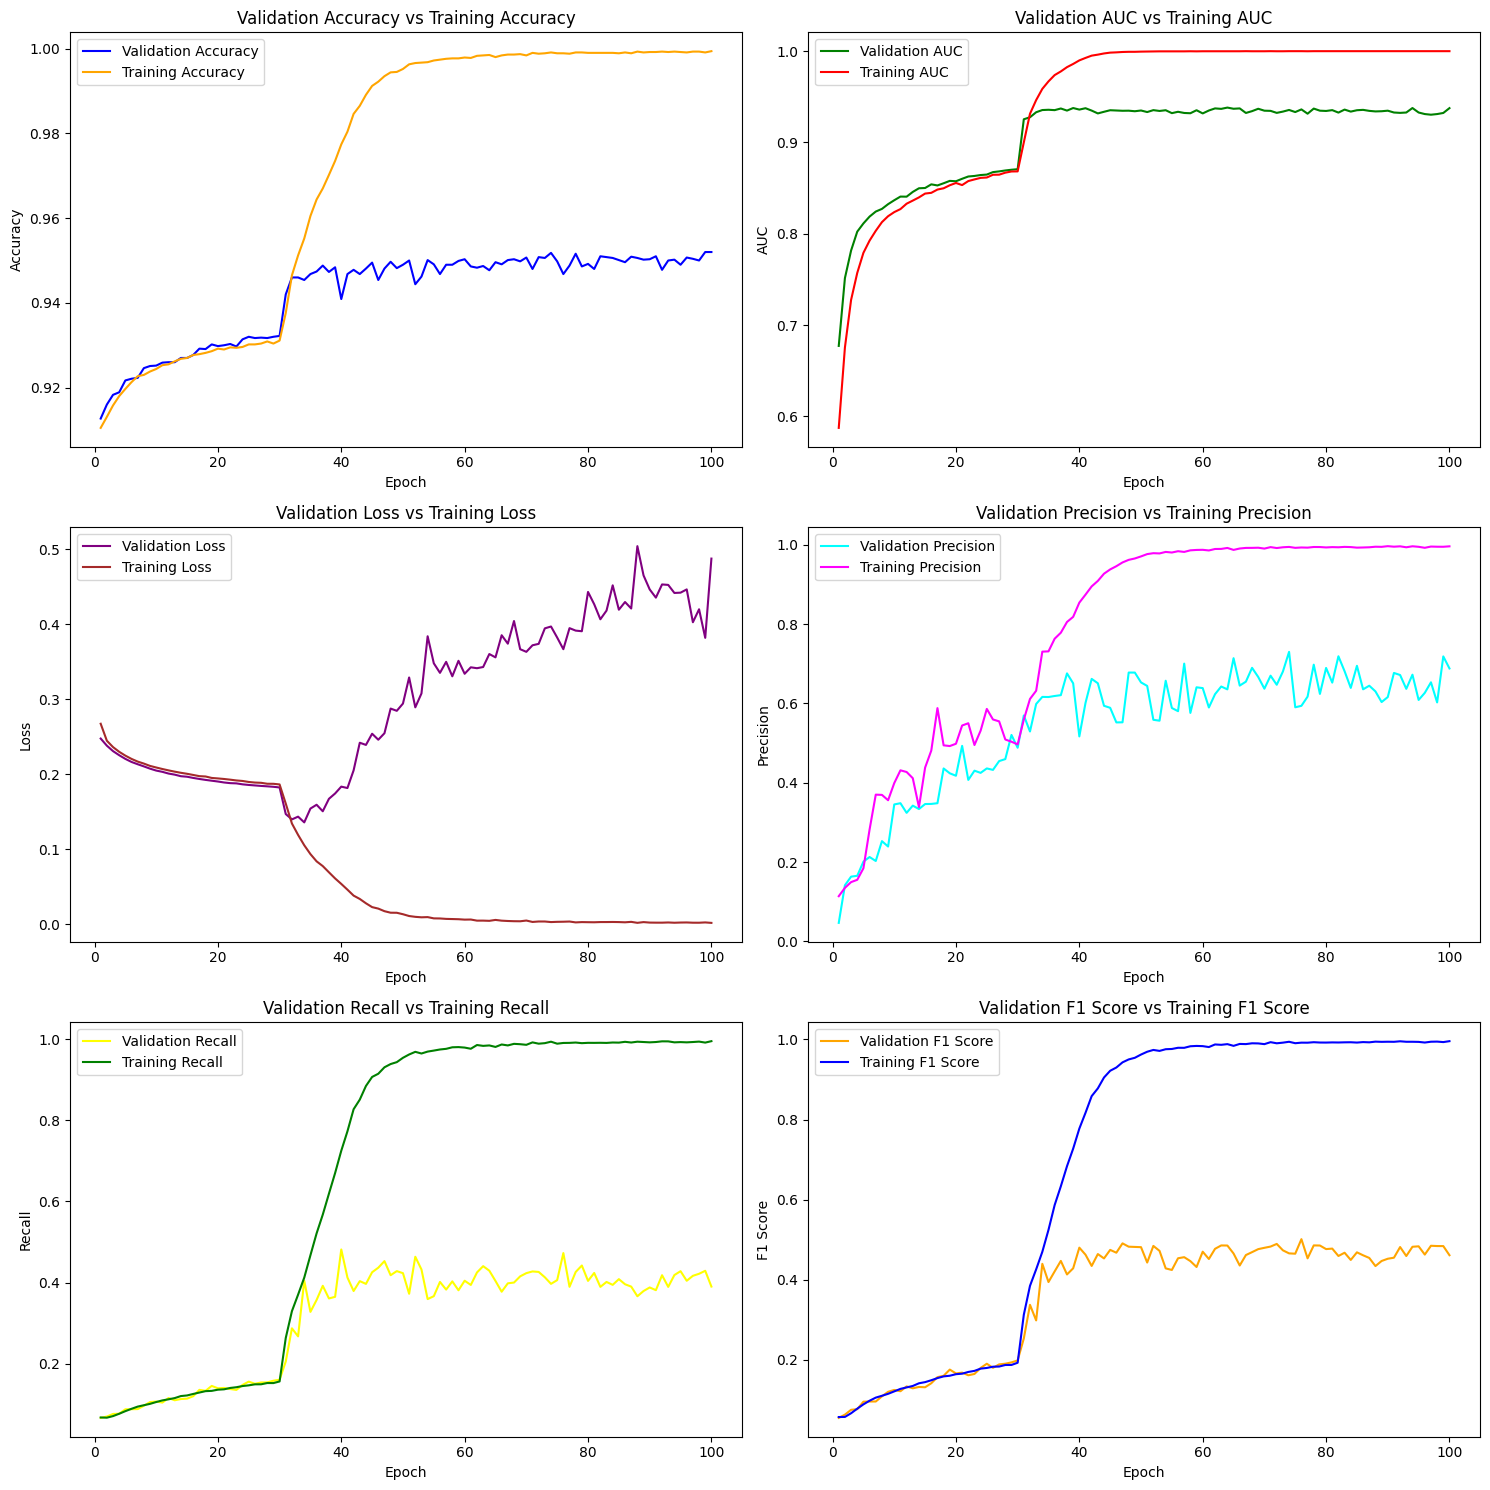

In [29]:
import pandas as pd
import matplotlib.pyplot as plt


# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot accuracy
axes[0, 0].plot(history['epoch_number'], history['val_accuracy'], label='Validation Accuracy', color='blue')
axes[0, 0].plot(history['epoch_number'], history['train_accuracy'], label='Training Accuracy', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Validation Accuracy vs Training Accuracy')
axes[0, 0].legend()

# Plot AUC
axes[0, 1].plot(history['epoch_number'], history['val_auc'], label='Validation AUC', color='green')
axes[0, 1].plot(history['epoch_number'], history['train_auc'], label='Training AUC', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC vs Training AUC')
axes[0, 1].legend()

# Plot loss
axes[1, 0].plot(history['epoch_number'], history['val_loss'], label='Validation Loss', color='purple')
axes[1, 0].plot(history['epoch_number'], history['train_loss'], label='Training Loss', color='brown')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Validation Loss vs Training Loss')
axes[1, 0].legend()

# Plot precision
axes[1, 1].plot(history['epoch_number'], history['val_precision'], label='Validation Precision', color='cyan')
axes[1, 1].plot(history['epoch_number'], history['train_precision'], label='Training Precision', color='magenta')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Validation Precision vs Training Precision')
axes[1, 1].legend()

# Plot recall
axes[2, 0].plot(history['epoch_number'], history['val_recall'], label='Validation Recall', color='yellow')
axes[2, 0].plot(history['epoch_number'], history['train_recall'], label='Training Recall', color='green')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Recall')
axes[2, 0].set_title('Validation Recall vs Training Recall')
axes[2, 0].legend()

# Plot F1 score
axes[2, 1].plot(history['epoch_number'], history['val_f1'], label='Validation F1 Score', color='orange')
axes[2, 1].plot(history['epoch_number'], history['train_f1'], label='Training F1 Score', color='blue')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('F1 Score')
axes[2, 1].set_title('Validation F1 Score vs Training F1 Score')
axes[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [33]:
# model_path = '/kaggle/working/best_model_precision.pth'
model_path = '/kaggle/input/28-03-2024-vinbigdata-swin-multilabel-weights/best_model_precision.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [34]:
test_scores_all = []
test_labels_all = []
test_predictions_all = []

correct_test = 0
total_test = 0


# Don't need to keep track of gradients
with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    start = timer()
    #Test loop
    for batch_data in tqdm(test_loader):
        inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.float()


        scores = torch.sigmoid(outputs)
        predictions = torch.sigmoid(outputs) > 0.5
        total_test += labels.size(0) * labels.size(1)

        correct_test += (predictions == labels).sum().item()

        test_scores_all.extend(scores.detach().cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())
        test_predictions_all.extend(predictions.cpu().numpy())

    accuracy_test = correct_test / total_test

    print(f"Accuracy: {accuracy_test:.4f}")
    print("correct:", correct_test, " out of ", total_test)

    test_predictions_all = np.array(test_predictions_all).astype(float)
    test_labels_all = np.array(test_labels_all).astype(float)

    print(classification_report(test_labels_all, test_predictions_all, target_names=disease_labels)) # adjust the target_names

    cm = multilabel_confusion_matrix(test_predictions_all, test_labels_all)
    # we will use macro-averaging strategy.
    accuracy_arr = []
    precision_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(num_classes):
        print(cm[i])
        print(cm[i].sum())

#         cfm_plot = sn.heatmap(cm[i], annot=False)
         # TP + TN / TP + TN  + FP + FN
        accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

        # TP / TP + FP
        precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

        # TP / TP + FN
        recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
        f1 = (2*precision*recall)/(precision+recall)
        print(disease_labels[i],": ",round(accuracy*100,2),"%") ### disease or disease_labels
        print("Precision: ",round(precision,2))
        print("Recall:", round(recall,2))
        print("F1-Score:", round(f1,2))
        print('==========================================================')


        accuracy_arr.append(accuracy)
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)
    
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
            
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
    
    accuracy_macro_test = round(sum(accuracy_arr) / len(accuracy_arr), 4)
    precision_macro_test = round(sum(precision_arr) / len(precision_arr), 4)
    recall_macro_test = round(sum(recall_arr) / len(recall_arr), 4)
    f1_macro_test = round(sum(f1_arr) / len(f1_arr), 4)
    roc_auc_macro_test = round(roc_auc_score(test_labels_all, test_scores_all, average='macro'), 4)

    print("MACRO-averged metrics", end=':- ')
    print(f"accuracy: {accuracy_macro_test}, precision: {precision_macro_test}", end=', ')
    print(f"recall: {recall_macro_test}, f1: {f1_macro_test}, ROC_AUC: {roc_auc_macro_test}")

    infer_time = timer()-start
    print(f"INFERENCE TIME: {(infer_time):.4f} seconds")
    print("-"*120)

100%|██████████| 188/188 [00:22<00:00,  8.44it/s]

Accuracy: 0.9522
correct: 21425  out of  22500
                    precision    recall  f1-score   support

Aortic enlargement       0.86      0.80      0.83       309
       Atelectasis       0.67      0.11      0.19        18
     Calcification       0.50      0.13      0.21        45
      Cardiomegaly       0.87      0.84      0.85       241
     Consolidation       0.45      0.16      0.24        31
               ILD       0.58      0.32      0.42        34
      Infiltration       0.52      0.30      0.38        50
      Lung Opacity       0.63      0.37      0.47       113
       Nodule/Mass       0.56      0.12      0.20        83
      Other lesion       0.41      0.16      0.23       109
  Pleural effusion       0.84      0.63      0.72        94
Pleural thickening       0.51      0.51      0.51       184
      Pneumothorax       0.00      0.00      0.00         8
Pulmonary fibrosis       0.59      0.47      0.53       144
        No finding       0.95      0.98      0.96   


/tmp/ipykernel_33/378300511.py:60: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
